In [88]:
from linares_plot import *
import scipy.io as io
import pickle
from scipy.ndimage import gaussian_filter
from scipy import misc
import os
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [89]:
def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)

In [90]:
path_ = '/home/david/Desktop/brian_simulations_albert/simulations5'
all_= os.listdir(path_)

In [91]:
N0 = 20000
time_s =7
N=0.8*N0 #(el 80% son excitadoras)
rounding = 2 ##round the timing
w=10 #100ms

In [92]:
### Reshape data from simulations

In [93]:
pos_stim=[]
Iexts = []
firings_wind = []

for sim_ in range(len(all_)): 
    print(sim_)
    simx = io.loadmat(path_ + '\\' + all_[sim_])
    ####
    #### save position and I0E of each simulation
    ####
    pos_stim.append(360*simx['pos_stim'][0][0])
    Iexts.append(simx['IEext'][0][0])
    ####
    #### For each simulation I will calculate the firing rate in windows of 100ms
    ####
    ####
    #### STEP 1: put all the spikes in the shape (neuron, time) ##time dimension here is 700
    ####
    spikes = simx['spktm'] ##all the spike times
    Matrix_spikes = np.zeros([int(0.8*N0), time_s*10**2])
    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])
    times_ = np.array([int(spikes[1][x]*10**rounding) for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    for t, n in zip(times_, neurons_ ):
        Matrix_spikes[n,t]=1
    ##
    ####
    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    f = np.shape(Matrix_spikes)[1] #700
    t1s = np.arange(0,f,w)
    t2s = np.arange(w,f+w,w)
    ##
    fr_time = []
    for N in range(np.shape(Matrix_spikes)[0]):
        neuron_fr = []
        for i in range(len(t1s)):
            neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ (w*time_s/f) ) ## works fine, same methos as in the function
        #
        fr_time.append(neuron_fr)
    ###
    fr_time=np.array(fr_time)
    ####
    #### STEP 3: save the new matrix, this time with the dimension (neuron, time) ##time dimension is 700/w = 70
    ####
    firings_wind.append(fr_time)
    

##
IExts = np.array(Iexts) 
Positions=np.array(pos_stim)
firings_wind = np.array(firings_wind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
### Calculate ROC and AUC per time

In [94]:
Neurons_  = np.arange(0,16000,10) ## np.arange(0,16000,1) 
Windows_ =np.arange(0,70,1)  ## np.arange(0,70,1)

In [ ]:
Iext_ = [0, 1.25]


lim_RF = 45/4 ##limit to consider a position is inside the RF of the neuron
base_fpr = np.linspace(0, 1, 101)

number_Iexs = len(Iext_)
number_neurons=len(Neurons_)
number_windows = len(Windows_)


auc_ = np.zeros((number_Iexs, number_windows, number_neurons))
#tprs_ =np.zeros((number_Iexs, number_windows))


for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        print(IEXT, wind)
        for idx_neuron, Neuron in enumerate(Neurons_):
            ###
            ### Get the positions of the appropiate Iext
            nx_positions=Positions[IExts==IEXT]
            ###
            ### Get the simulations of the appropiate Iext
            nx_rates_iex = firings_wind[IExts==IEXT]
            ###
            ### Get the firing of the neuron at a certain window in each simulation
            nx_rates = np.array([nx_rates_iex[n][Neuron, wind] for n in range(len(nx_rates_iex))])
            ###
            dfx = pd.DataFrame({'position':nx_positions, 'rate':nx_rates, 'Neuron':Neuron, 'wind':wind})
            ###
            ### RF center of each neuro
            index_max_rate = np.where(dfx['rate']==dfx['rate'].max())[0][0]
            RF_center = dfx['position'].iloc[index_max_rate]
            dfx['RF_center'] = RF_center
            in_out_rf = []
            for p in range(len(dfx)):
                dist_ = circ_dist(RF_center, dfx.position.iloc[p])
                if dist_>lim_RF:
                    in_out_rf.append(5) #outside RF
                else:
                    in_out_rf.append(1) #inside RF
            #####
            dfx['in_out_rf']=in_out_rf
            ###
            ## appropiate shape for the classifier
            y = label_binarize(dfx['in_out_rf'].values, classes=[5,1]) #matrix (1,0,0,...,0)
            y=y.ravel()
            ######
            if len(np.unique(y))==1:
                mean_tprs = np.empty(np.shape(base_fpr))*np.nan
            else:
                fpr, tpr, _ = roc_curve(y, dfx['rate'].values) #HERE: compute ROC with raw firing rate
                tpr = np.interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                mean_tprs = tpr
            
            #tprs_[idx_Iext, idx_wind] = mean_tprs
            ##
            auc_[idx_Iext, idx_wind, idx_neuron] = auc(base_fpr, mean_tprs)
            ##


            

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34


In [ ]:
### Mean AUC of all neurons in each Iex and window

Mean_auc = []
exts=[]
times_=[]

for idx_Iext, IEXT in enumerate(Iext_):
    for idx_wind, wind in enumerate(Windows_):
        auc_wind = auc_[idx_Iext, idx_wind, :] 
        ind = np.isnan(auc_wind)
        ##
        Mean_auc.append(np.mean(auc_wind[~ind]) )
        exts.append(IEXT)
        times_.append(wind*w)
        
##

df_mean_auc = pd.DataFrame({'AUC':Mean_auc, 'Iext':exts, 'time':times_})
df_mean_auc[' '] = df_mean_auc['Iext'].replace([0,1.25], ['OFF', 'ON'])

In [78]:
## Plot AUC with time in ON and OFF conditions

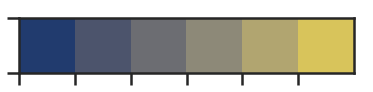

In [79]:
pal_= sns.color_palette("cividis", n_colors=6) #RdBu_r
sns.palplot(pal_)
plt.show()
palette_ = [pal_.as_hex()[0], pal_.as_hex()[-1]]

In [ ]:
ax=plt.figure()


sns.lineplot(x='time', y='AUC', hue=' ', hue_order=['OFF', 'ON'], data=df_mean_auc, palette=palette_)
plt.xlim(10,700)
plt.xticks([100,250,400,550,700], fontsize=20)
plt.ylim([0.5, 1.])
plt.yticks([0.5, 0.75, 1], fontsize=20)
plt.ylabel('AUC', fontsize=25)
plt.xlabel('time (ms)', fontsize=25)
plt.title('')
plt.legend(loc="lower right", fontsize=20, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
#plt.plot([200,200], [0.5, 0.95], 'k--', linewidth=1)
#plt.plot([300,300], [0.5, 0.95], 'k--', linewidth=1)
plt.fill_between([200,300], [0.95, 0.95], color='lightgrey')
plt.show()

ax.savefig('C:\\Users\\David\\Desktop\\AUC_Hansel_all.svg', transparent=True)

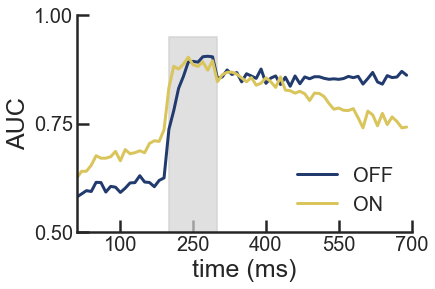

In [87]:
ax=plt.figure()


sns.lineplot(x='time', y='AUC', hue=' ', hue_order=['OFF', 'ON'], data=df_mean_auc, palette=palette_)
plt.xlim(10,700)
plt.ylim([0.5, 1.])
plt.yticks([0.5, 0.75, 1], fontsize=20)
plt.ylabel('AUC', fontsize=25)
plt.xlabel('time (ms)', fontsize=25)
plt.title('')
plt.legend(loc="lower right", fontsize=20, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
#plt.plot([200,200], [0.5, 0.95], 'k--', linewidth=1)
#plt.plot([300,300], [0.5, 0.95], 'k--', linewidth=1)
plt.fill_between([200,300], [0.95, 0.95], color='lightgrey', alpha=0.7)
plt.xticks([100,250,400,550,700], fontsize=20)
plt.show()

ax.savefig('C:\\Users\\David\\Desktop\\AUC_Hansel.svg', transparent=True)